<a href="https://colab.research.google.com/github/satishgaurav/DeepChem_MolGAN/blob/master/gan_with_mol_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/satishgaurav/DeepChem_MolGAN.git
%cd DeepChem_MolGAN

fatal: destination path 'DeepChem_MolGAN' already exists and is not an empty directory.
/content/DeepChem_MolGAN


In [2]:
!pwd

/content/DeepChem_MolGAN


In [3]:
## Print all variable
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
## Install deepchem 
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  11114      0 --:--:-- --:--:-- --:--:-- 11114


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
remove current miniconda
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [5]:
import tensorflow as tf 
import numpy as np 
import deepchem as dc
import rdkit as rdkit
import rdkit.Chem as Chem
import rdkit.Chem.PandasTools as pt
import pandas as pd

In [6]:
print('Tensorflow version:', tf.__version__) 
print('GPU avilable:', tf.test.gpu_device_name())
print('RDKit version: ', rdkit.__version__)
print('DeepChem version', dc.__version__)

Tensorflow version: 2.4.1
GPU avilable: 
RDKit version:  2020.09.1
DeepChem version 2.6.0.dev


In [7]:
data = pd.read_csv('data/QM9_HAC_5_9_.csv')
data.head()

,SMILES
0,CC(C)=NO
1,N1C=CC=C1
2,N1C=CN=C1
3,O1C=CC=C1
4,O1C=CN=C1


In [8]:
reduced_data = list(data['SMILES'])
import random
random.shuffle(reduced_data)

In [9]:
mols = list(filter(lambda x: x is not None, [Chem.MolFromSmiles(x) for x in reduced_data]))
print('No. of molecules obtained: ', len(mols))

No. of molecules obtained:  132432


In [51]:
%%bash 

rm -r data/images  ## remove if you want to created a new one!

directory_name='./data/images/'
if [ -d "$directory_name" ]; then
    echo "$directory_name exists as a directory!"
else
    mkdir $directory_name
    cd $directory_name 
    mkdir color
    mkdir gray
    echo "$directory_name didn't existed, creted the same!"
    echo "color dir. created"
    echo "gray dir. created"
fi

./data/images/ didn't existed, creted the same!
color dir. created
gray dir. created


In [52]:
from rdkit.Chem.Draw import rdMolDraw2D

image_path = "./data/images/color/"

for mol in mols[0:10]:
  d = rdMolDraw2D.MolDraw2DCairo(28, 28)
  rdMolDraw2D.PrepareAndDrawMolecule(d,mol)
  mol_name = Chem.MolToSmiles(mol)
  d.WriteDrawingText("%s%s.png" % (image_path, mol_name))

In [53]:
mols_list = list(filter(lambda x: x is not None, [Chem.MolToSmiles(x) for x in mols[0:5]]))
print(mols_list)

['C#Cc1coc(=O)[nH]1', 'N#C[C@H](O)C1CC(=O)C1', 'N#Cc1nnn(C=O)n1', 'CO[C@H]1[C@@H](N)[C@H]1C(=O)O', 'C[C@H]1C[C@@H](C)C12CC2']


In [54]:
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

In [58]:
import cv2
from os import listdir, makedirs
from os.path import isfile, join

path = r'./data/images/color' # Source Folder
dstpath = r'./data/images/gray' # Destination Folder

# try:
#     makedirs(dstpath)
# except:
#     print ("Directory already exist, images will be written in the same folder")

# Folder won't used
files = [f for f in listdir(path) if isfile(join(path,f))] 

for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath, image)
        print(dstPath)
        cv2.imwrite(dstPath, gray)
    except:
        print ("{} is not converted".format(image))
        print(dstPath)

N#C[C@H](O)C1CC(=O)C1.png is not converted


NameError: ignored

In [15]:
import glob
from PIL import Image
mols_list = glob.glob('./data/images/*.png')
x = np.array([np.array(Image.open(mol_name)) for mol_name in mols_list])

In [25]:
x.shape

(199, 28, 28, 3)

In [26]:
images = x.reshape((-1, 28, 28, 1))/255
print(images.shape)
dataset = dc.data.NumpyDataset(images)
print(dataset.get_shape())

(597, 28, 28, 1)
((597, 28, 28, 1), (597, 1), (597, 1), (597,))


In [18]:
type(images)

numpy.ndarray

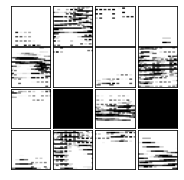

In [24]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')
plot_digits(images)

In [21]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

In [23]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(10), generator_steps=0.2, checkpoint_interval=5000)

ValueError: ignored

## References: 
  1. https://www.rdkit.org/docs/GettingStartedInPython.html